In [1]:
import time
start_time=time.time()

Abstract

Se presenta un ajuste polinomial (0-6 ord) a los datos observacionales para investigar movimientos a gran escala (detrended data) en direciones X y Y.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d
from scipy import interpolate

from SABReXX import sosf,acf,psk,ps,sosfnorm,sosfw,sosfw2,sosfs,sosfnorms,sfwh,pst
from CorrPoldef import CPV,CPH
from LRdefX import LR,ACLR
from Pltdef import pltdata

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

Input Data

In [3]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
lr=[6562.8,6548,6583,6717,6731]#AngstromsR
#lb=[4861.36,4958.9,5006.9]#AngstromsB


n=7

Astronomical Observations

In [4]:
inputf='604.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})


In [5]:
#LimitData
min0=65
max0=145
mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

Emission lines data

In [6]:
for i in range(1):
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-lr[Nx])/lr[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('dataI'+str(int(lr[Nx]))+'.csv')

# Muestra (i) H alfa

In [7]:
datap='dataI6562.csv'
dt=pd.read_csv(datap)
dt=dt.rename(columns={'Unnamed: 0':'No'})
dt=dt.drop('No',axis=1)
os.remove(datap)
dt.describe()

,X,Y,RV,I
count,600.000000,600.000000,600.000000,600.000000
mean,105.269000,9.390000,-250.043594,2277.239467
std,23.243169,6.256047,10.420092,3750.107456
min,65.710000,0.000000,-277.593319,27.150000
25%,85.485000,4.000000,-257.836471,281.925000
50%,105.270000,9.000000,-249.888052,1017.500000
75%,125.045000,15.000000,-244.018098,2403.500000
max,144.830000,19.600000,-205.463695,30960.000000


In [8]:
wd=dt.X.max()-dt.X.min()
hd=dt.Y.max()-dt.Y.min()
ar=wd/hd
sz=4

Statistical Data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


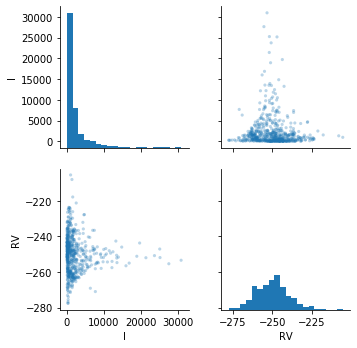

In [9]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


Emission Map

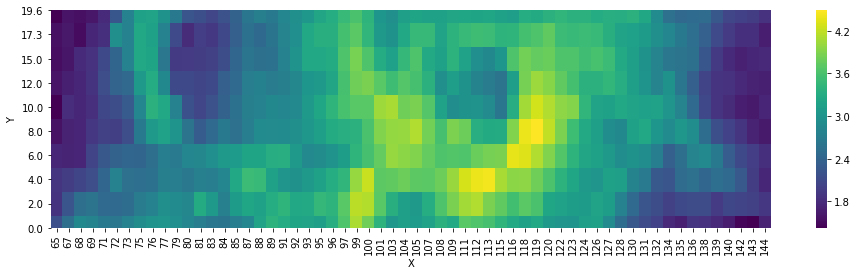

In [10]:
datal=dt.copy()
datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
#datal.Y=datal.Y.astype(int)

dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_f, cmap="viridis",xticklabels='auto')
plt.gca().invert_yaxis()
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="16"

Radial Velocity

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


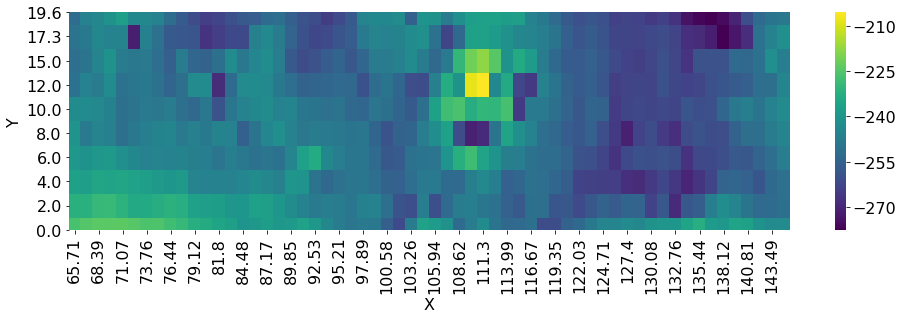

In [11]:
datal=dt.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Weighted property

In [12]:
W=np.log(abs((dt.RV*dt.I)/dt.I.sum()))
W.head()

0   -4.307465
1   -4.062174
2   -3.976022
3   -3.793160
4   -3.335217
dtype: float64

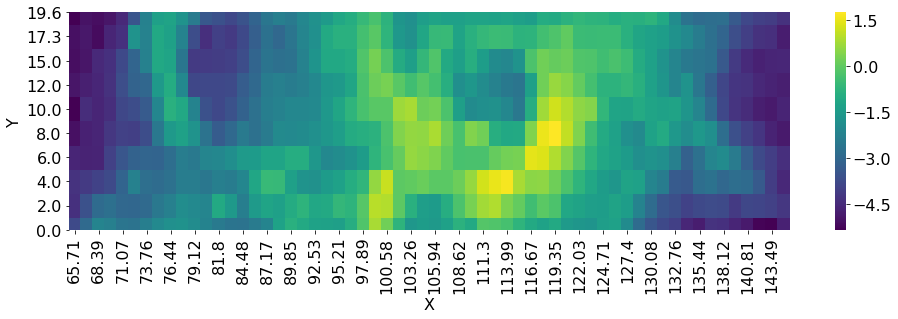

In [13]:
dtW=[dt.X,dt.Y,W]
dtW=pd.DataFrame(dtW).T
dtW.columns=['X','Y','W']

dtH_W=(dtW.round(2)).pivot(index='Y', columns='X', values='W')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dtH_W, cmap="viridis")
plt.gca().invert_yaxis()


Horizontal Polynomial Correction

 
-250
 
-0.1871 x - 230.4
           2
0.0005181 x - 0.2961 x - 224.9
           3           2
4.633e-05 x - 0.01411 x + 1.199 x - 274.2
           4            3         2
1.594e-05 x - 0.006664 x + 1.023 x - 68.51 x + 1442
           5             4           3         2
5.687e-07 x - 0.0002834 x + 0.05534 x - 5.289 x + 247.1 x - 4757
            6             5            4          3         2
-1.018e-08 x + 6.999e-06 x - 0.001953 x + 0.2834 x - 22.56 x + 934.8 x - 1.599e+04


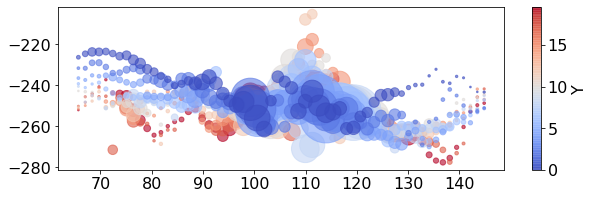

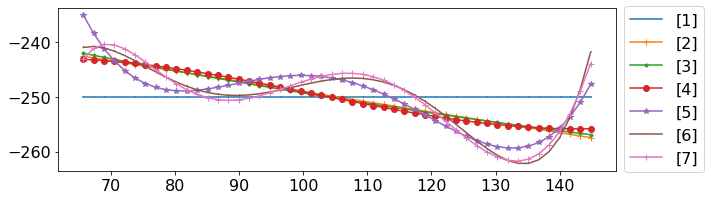

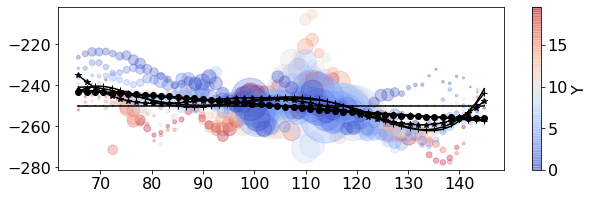

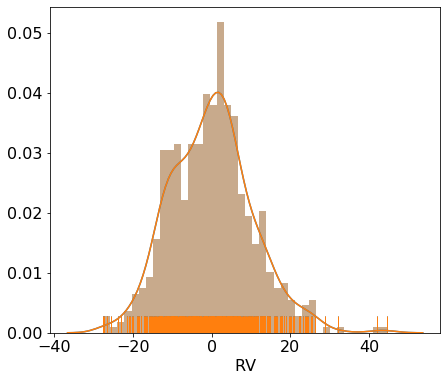

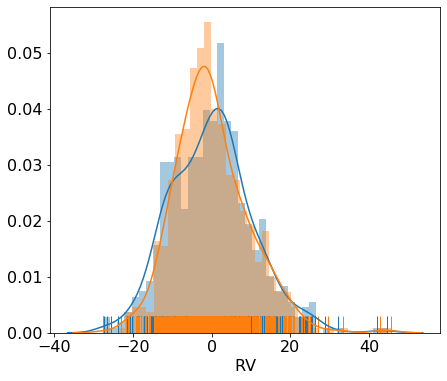

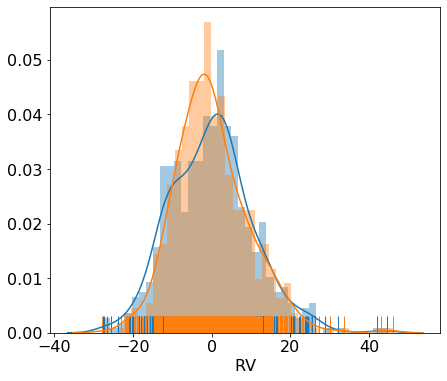

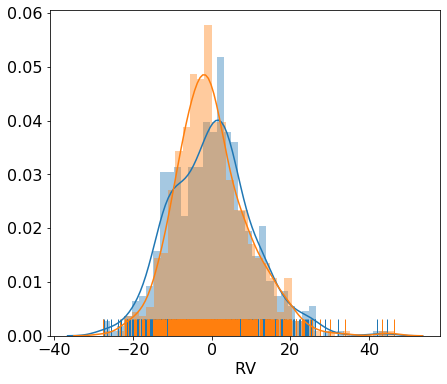

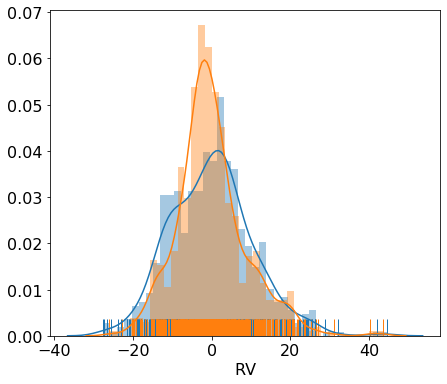

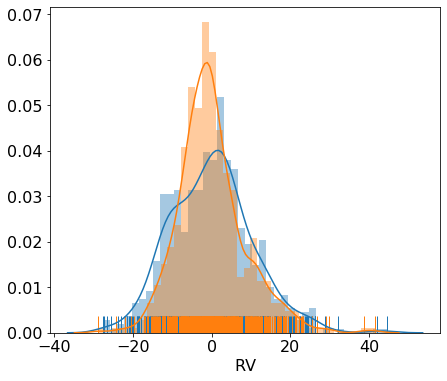

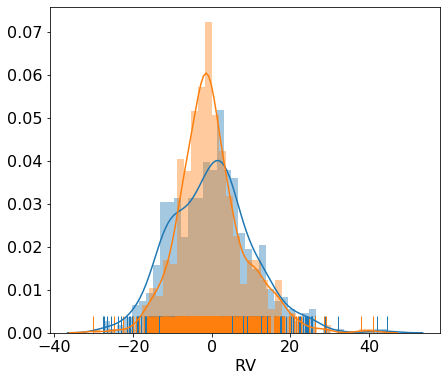

In [14]:
argo1=CPH(dt,n)

Vertical Polynomial Correction

 
-250
 
-0.4515 x - 245.8
         2
0.03189 x - 1.077 x - 244
           3          2
-0.008668 x + 0.2847 x - 2.928 x - 241.8
           4           3          2
0.0008795 x - 0.04305 x + 0.7038 x - 4.56 x - 240.9
           5            4            3          2
4.636e-05 x - 0.001387 x - 0.004431 x + 0.4377 x - 3.937 x - 241
           6            5           4          3         2
2.326e-05 x - 0.001307 x + 0.02806 x - 0.2988 x + 1.757 x - 6.007 x - 240.8


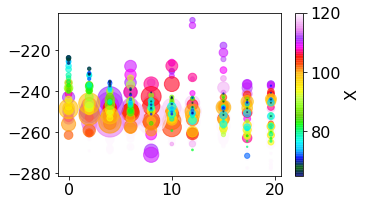

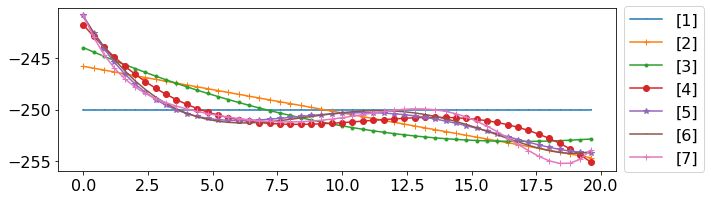

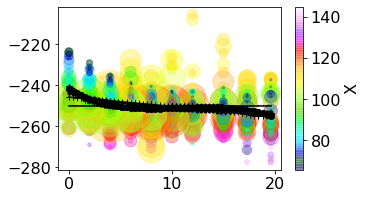

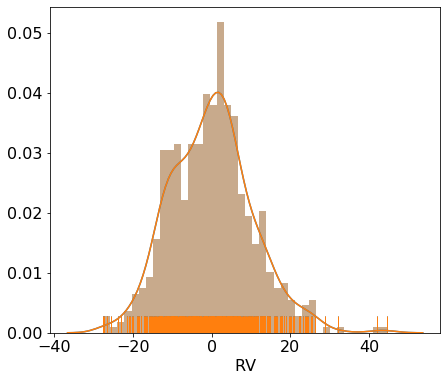

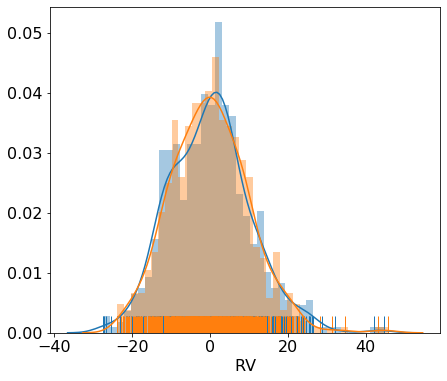

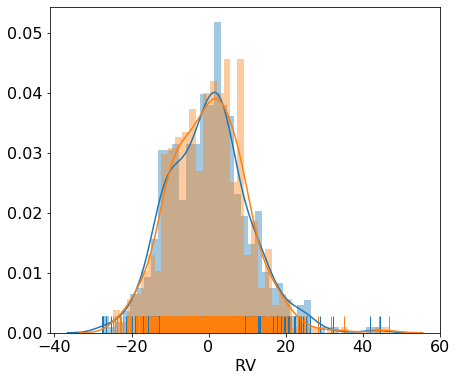

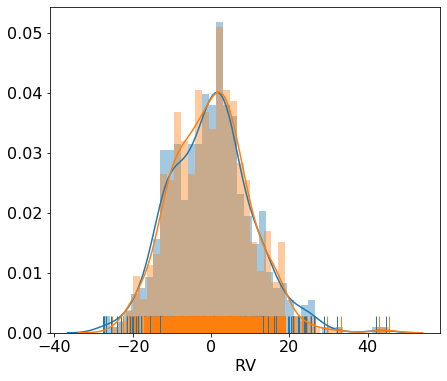

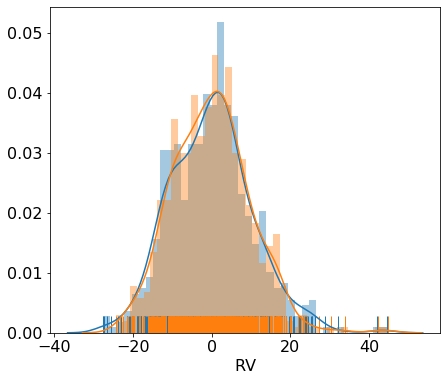

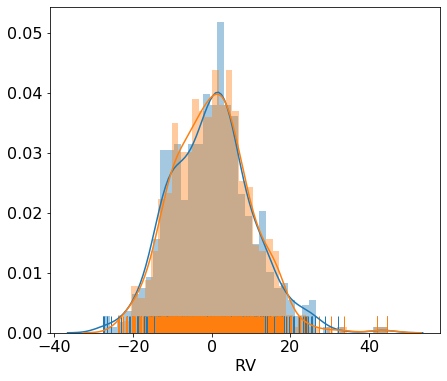

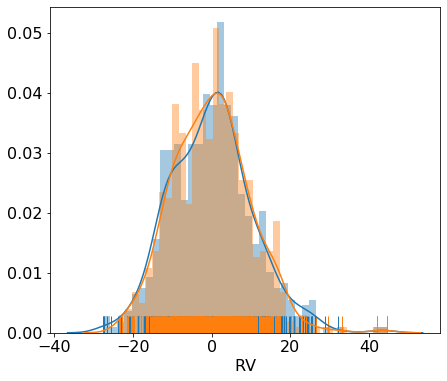

In [15]:
argo2=CPV(dt,n)

Structure Function

In [16]:
SF1=dict()

for i in range(n):
    SF1[i]=sosf(argo1[i])
    
SF2=dict()

for i in range(n):
    SF2[i]=sosf(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [17]:
xi=1
xf=15

SF1Data=dict()
SF1Pr=dict()

for i in range(n):
    SF1Data[i],SF1Pr[i]=LR(SF1[i]['Lag'],SF1[i]['Nmqvd'],SF1[i]['ErrY'],xi,xf,n)
    
SF2Data=dict()
SF2Pr=dict()


for i in range(n):
    SF2Data,SF2Pr[i]=LR(SF2[i]['Lag'],SF2[i]['Nmqvd'],SF2[i]['ErrY'],xi,xf,n)

In [18]:
SF1Data,SF2Data

({0:               R        eps     alpha    lags
  Value  0.996650  41.564976  0.584880   2.667
  Err    0.000263   0.967207  0.006492  20.095,
  1:               R        eps     alpha    lags
  Value  0.996573  42.752541  0.566093   2.667
  Err    0.000093   0.997773  0.006507  20.095,
  2:               R        eps     alpha    lags
  Value  0.996551  42.723619  0.565816   2.667
  Err    0.000110   0.996595  0.006497  20.095,
  3:               R        eps     alpha    lags
  Value  0.996559  42.595483  0.565608   2.667
  Err    0.000148   0.994096  0.006492  20.095,
  4:               R        eps     alpha    lags
  Value  0.994300  46.477801  0.493182   2.667
  Err    0.000017   1.093528  0.006524  20.095,
  5:               R        eps     alpha    lags
  Value  0.987979  49.971046  0.442126   2.667
  Err    0.000335   1.179521  0.006524  20.095,
  6:               R        eps     alpha    lags
  Value  0.988286  49.810991  0.440943   2.667
  Err    0.000288   1.183761  0.0

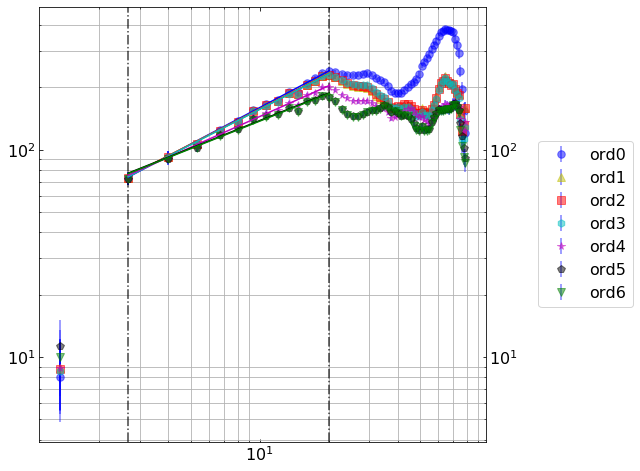

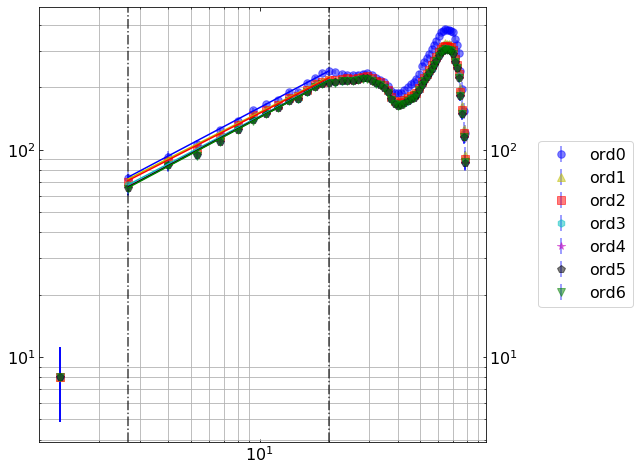

In [19]:
pltdata(SF1,SF1Pr,xi,xf,n)
pltdata(SF2,SF2Pr,xi,xf,n)

Structure Function Norm

In [20]:
SFn1=dict()

for i in range(n):
    SFn1[i]=sosfnorm(argo1[i])
    
SFn2=dict()

for i in range(n):
    SFn2[i]=sosfnorm(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [21]:
xi=1
xf=15

SFN1Data=dict()
SFN1Pr=dict()

for i in range(n):
    SFN1Data[i],SFN1Pr[i]=LR(SFn1[i]['Lag'],SFn1[i]['Nmqvd'],SFn1[i]['ErrY'],xi,xf,n)
    
SFN2Data=dict()
SFN2Pr=dict()

for i in range(n):
    SFN2Data[i],SFN2Pr[i]=LR(SFn2[i]['Lag'],SFn2[i]['Nmqvd'],SFn2[i]['ErrY'],xi,xf,n)

In [22]:
SFN1Data,SFN2Data

({0:               R       eps     alpha    lags
  Value  0.996626  0.383443  0.584898   2.667
  Err    0.000268  0.008931  0.006499  20.095,
  1:               R       eps     alpha    lags
  Value  0.996575  0.477473  0.566169   2.667
  Err    0.000095  0.011105  0.006473  20.095,
  2:               R       eps     alpha    lags
  Value  0.996576  0.477694  0.565712   2.667
  Err    0.000113  0.011104  0.006467  20.095,
  3:               R       eps     alpha    lags
  Value  0.996530  0.477106  0.565722   2.667
  Err    0.000153  0.011092  0.006465  20.095,
  4:               R       eps     alpha    lags
  Value  0.994314  0.586697  0.493148   2.667
  Err    0.000019  0.013760  0.006498  20.095,
  5:               R       eps     alpha    lags
  Value  0.987966  0.675007  0.442136   2.667
  Err    0.000336  0.015985  0.006544  20.095,
  6:               R       eps     alpha    lags
  Value  0.988273  0.678878  0.440994   2.667
  Err    0.000277  0.016055  0.006567  20.095},
 {0: 

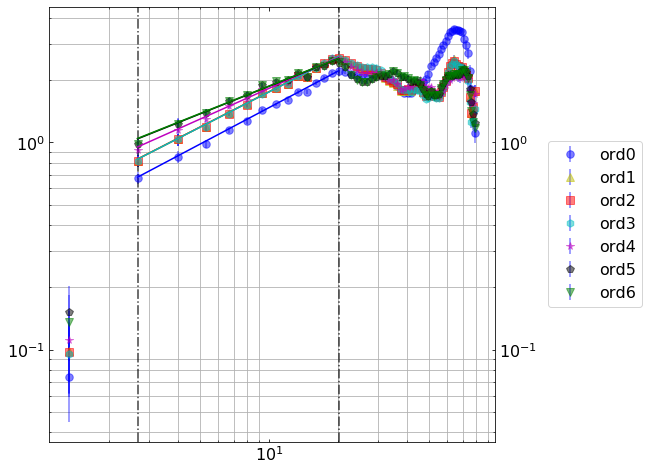

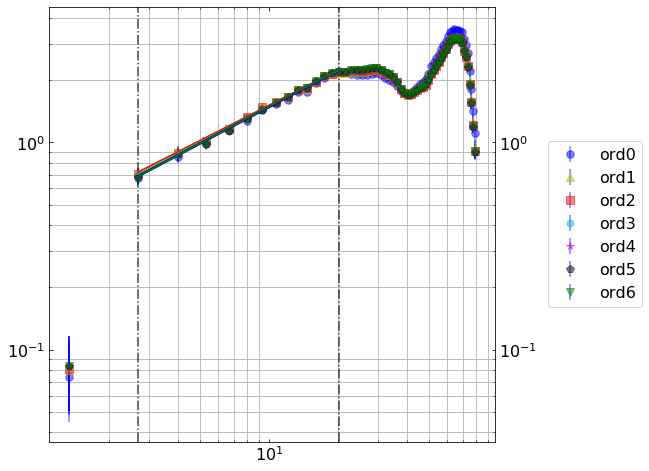

In [23]:
pltdata(SFn1,SFN1Pr,xi,xf,n)
pltdata(SFn2,SFN2Pr,xi,xf,n)

Weighted Structure Function

In [24]:
SFw1=dict()

for i in range(n):
    SFw1[i]=sosfw(argo1[i])

SFw2=dict()

for i in range(n):
    SFw2[i]=sosfw(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1171: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1180: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [25]:
xi=1
xf=8

SFW1Data=dict()
SFW1Pr=dict()


for i in range(n):
    SFW1Data[i],SFW1Pr[i]=LR(SFw1[i]['Lag'],SFw1[i]['Nmqvd'],SFw1[i]['ErrY'],xi,xf,n)
    
SFW2Data=dict()
SFW2Pr=dict()


for i in range(n):
    SFW2Data[i],SFW2Pr[i]=LR(SFw2[i]['Lag'],SFw2[i]['Nmqvd'],SFw2[i]['ErrY'],xi,xf,n)

In [26]:
SFW1Data,SFW2Data

({0:               R       eps     alpha    lags
  Value  0.826720  4.111159  0.341669   2.667
  Err    0.024585  0.216312  0.016777  10.668,
  1:               R       eps     alpha    lags
  Value  0.817276  5.015431  0.323035   2.667
  Err    0.026023  0.263090  0.016549  10.668,
  2:               R       eps     alpha    lags
  Value  0.819274  5.009373  0.325299   2.667
  Err    0.025705  0.262695  0.016556  10.668,
  3:               R       eps     alpha    lags
  Value  0.822996  5.001708  0.327492   2.667
  Err    0.025135  0.262045  0.016524  10.668,
  4:               R       eps     alpha    lags
  Value  0.788933  5.788754  0.286447   2.667
  Err    0.029781  0.299421  0.015739  10.668,
  5:               R       eps     alpha    lags
  Value  0.713883  6.497928  0.244433   2.667
  Err    0.041068  0.338983  0.015868  10.668,
  6:               R       eps     alpha    lags
  Value  0.721014  6.535975  0.243263   2.667
  Err    0.039810  0.338303  0.015552  10.668},
 {0: 

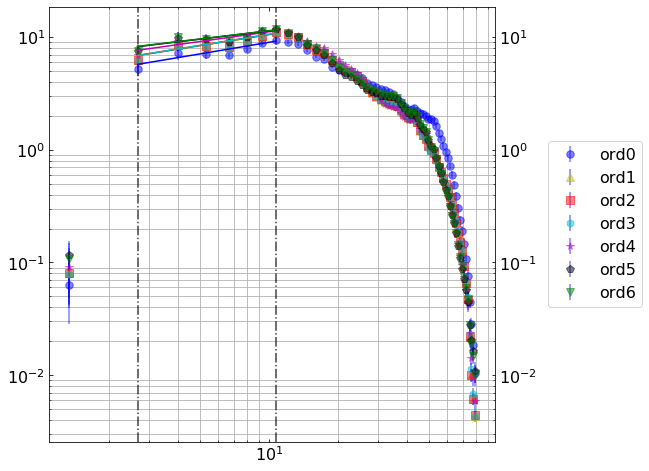

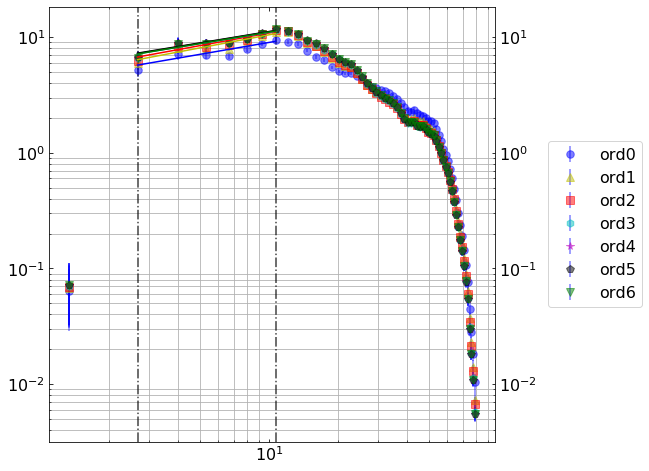

In [27]:
pltdata(SFw1,SFW1Pr,xi,xf,n)
pltdata(SFw2,SFW2Pr,xi,xf,n)

Weighted Property

In [28]:
SFwII1=dict()

for i in range(n):
    SFwII1[i]=sosfw2(argo1[i])
    
SFwII2=dict()

for i in range(n):
    SFwII2[i]=sosfw2(argo1[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1651: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [29]:
xi=1
xf=25

SFWII1Data=dict()
SFWII1Pr=dict()

for i in range(n):
    SFWII1Data[i],SFWII1Pr[i]=LR(SFwII1[i]['Lag'],SFwII1[i]['Nmqvd'],SFwII1[i]['ErrY'],xi,xf,n)
    
SFWII2Data=dict()
SFWII2Pr=dict()

for i in range(n):
    SFWII2Data[i],SFWII2Pr[i]=LR(SFwII2[i]['Lag'],SFwII2[i]['Nmqvd'],SFwII2[i]['ErrY'],xi,xf,n)

In [30]:
SFWII1Data,SFWII2Data

({0:               R       eps     alpha    lags
  Value  0.863246  1.560726  0.150758   2.667
  Err    0.007115  0.050190  0.007341  33.497,
  1:               R       eps     alpha    lags
  Value  0.874437  1.630563  0.149981   2.667
  Err    0.012648  0.053637  0.007477  33.497,
  2:               R       eps     alpha    lags
  Value  0.884730  1.599711  0.156816   2.667
  Err    0.012056  0.052499  0.007432  33.497,
  3:               R       eps     alpha    lags
  Value  0.897755  1.553996  0.167725   2.667
  Err    0.010062  0.050776  0.007388  33.497,
  4:               R       eps     alpha    lags
  Value  0.908020  1.582375  0.164791   2.667
  Err    0.010356  0.052786  0.007450  33.497,
  5:               R       eps     alpha    lags
  Value  0.711816  1.774646  0.122530   2.667
  Err    0.034994  0.059438  0.006803  33.497,
  6:               R       eps     alpha    lags
  Value  0.770802  1.707802  0.137942   2.667
  Err    0.030298  0.057704  0.006807  33.497},
 {0: 

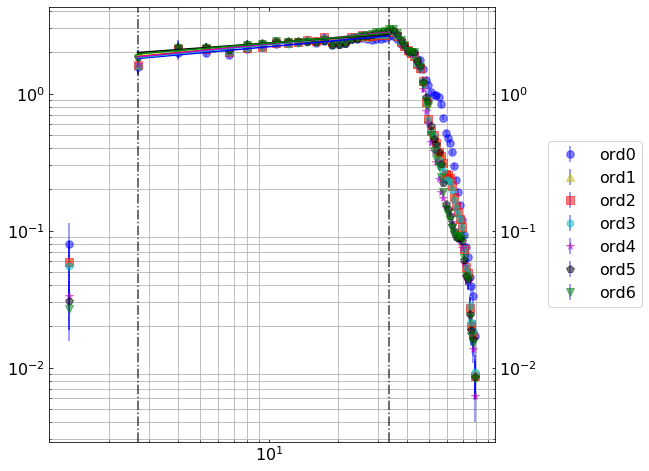

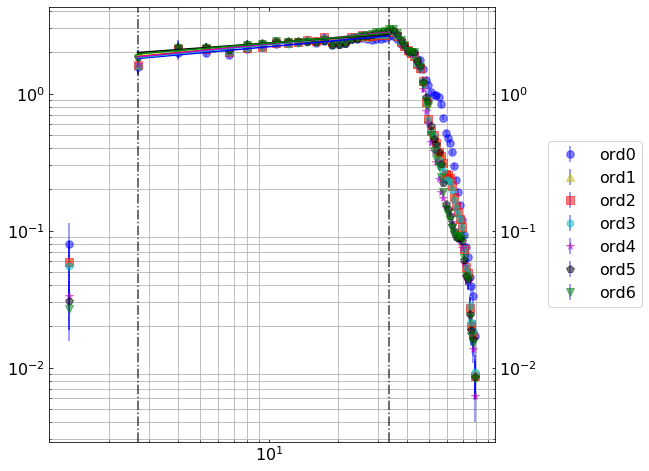

In [31]:
pltdata(SFwII1,SFWII1Pr,xi,xf,n)
pltdata(SFwII2,SFWII2Pr,xi,xf,n)

Structure Function Dr. Will

In [32]:
SFwh1=dict()

for i in range(n):
    SFwh1[i]=sfwh(argo1[i])
    
SFwh2=dict()

for i in range(n):
    SFwh2[i]=sfwh(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [33]:
xi=1
xf=65

SFwh1Data=dict()
SFwh1Pr=dict()

for i in range(n):
    SFwh1Data[i],SFwh1Pr[i]=LR(SFwh1[i]['Lag'],SFwh1[i]['Nmqvd'],SFwh1[i]['ErrY'],xi,xf,n)
    
SFwh2Data=dict()
SFwh2Pr=dict()

for i in range(n):
    SFwh2Data[i],SFwh2Pr[i]=LR(SFwh2[i]['Lag'],SFwh2[i]['Nmqvd'],SFwh2[i]['ErrY'],xi,xf,n)

In [34]:
SFwh1Data,SFwh2Data

({0:               R        eps     alpha    lags
  Value  0.882319  41.946511  0.605242   3.359
  Err    0.002129   1.274865  0.004667  21.076,
  1:               R        eps     alpha    lags
  Value  0.830294  46.416448  0.538320   3.359
  Err    0.002883   1.440384  0.004566  21.076,
  2:               R        eps     alpha    lags
  Value  0.825417  46.482959  0.535864   3.359
  Err    0.002893   1.440476  0.004513  21.076,
  3:               R        eps     alpha    lags
  Value  0.831998  45.825501  0.547130   3.359
  Err    0.002697   1.421865  0.004546  21.076,
  4:               R        eps     alpha    lags
  Value  0.784601  49.407232  0.486972   3.359
  Err    0.004158   1.687486  0.005621  21.076,
  5:               R        eps     alpha    lags
  Value  0.595798  62.109591  0.353417   3.359
  Err    0.006333   2.031915  0.004873  21.076,
  6:               R        eps     alpha    lags
  Value  0.597617  62.033102  0.355822   3.359
  Err    0.006576   2.043625  0.0

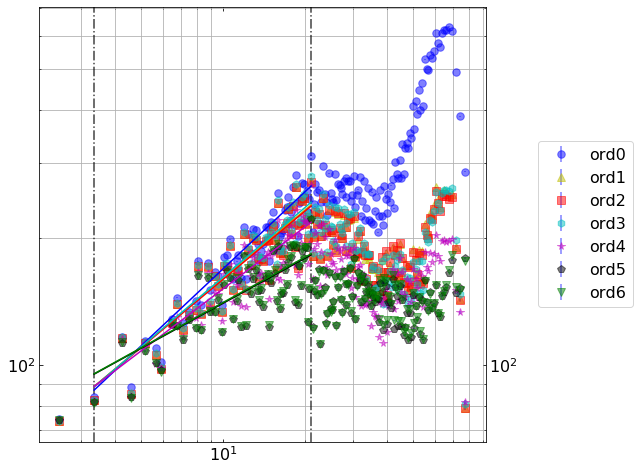

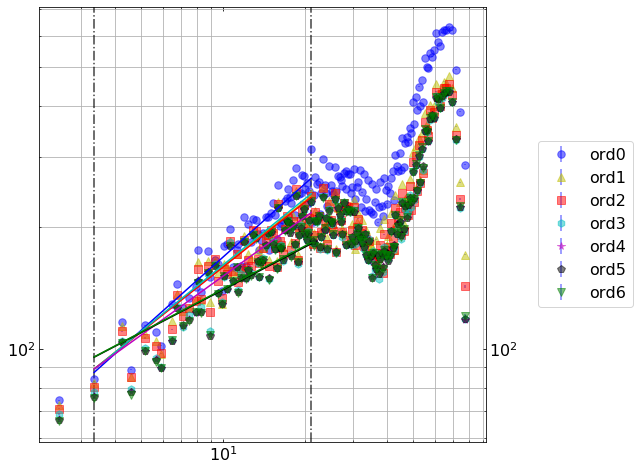

In [35]:
pltdata(SFwh1,SFwh1Pr,xi,xf,n)
pltdata(SFwh2,SFwh1Pr,xi,xf,n)

Autocorrelation Function

In [36]:
AF1=dict()

for i in range(n):
    AF1[i]=acf(argo1[i])
    
AF2=dict()

for i in range(n):
    AF2[i]=acf(argo2[i])

In [37]:
AF1Data=dict()
AF1Inter=dict()


for i in range(n):

    AF1Data[i],AF1Inter[i]=ACLR(AF1[i])
    
AF2Data=dict()
AF2Inter=dict()


for i in range(n):

    AF2Data[i],AF2Inter[i]=ACLR(AF2[i])
    

AF1Data,AF2Data 

({0: array([16.3986659 , 32.47169761, 47.05855858, 76.42698519]),
  1: array([12.69329787, 30.38554553, 50.13304325, 52.61910928, 54.14989331,
         73.35998311]),
  2: array([12.77257734, 30.58446463, 50.39803515, 52.10062732, 57.13159873,
         73.8730136 ]),
  3: array([12.85835823, 31.08136887, 54.83414302, 55.74318471, 56.44655401,
         73.83044347]),
  4: array([12.14110059, 28.07313794, 45.06547151, 66.68215471, 67.16809057,
         69.34503737, 70.41837341]),
  5: array([11.05815764, 23.68540129, 33.48441333, 40.72060455, 54.30659607,
         78.92065759]),
  6: array([11.05713331, 23.48237066, 33.72337401, 41.10697419, 50.76501205,
         51.17173662, 54.38733698])},
 {0: array([16.3986659 , 32.47169761, 47.05855858, 76.42698519]),
  1: array([16.56267454, 32.1343449 , 47.10809228, 76.20433701]),
  2: array([16.63796224, 32.13578936, 47.10564413, 76.22864203]),
  3: array([16.52825897, 32.10186789, 47.13116987, 76.21712537]),
  4: array([16.49089506, 32.05649951,

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


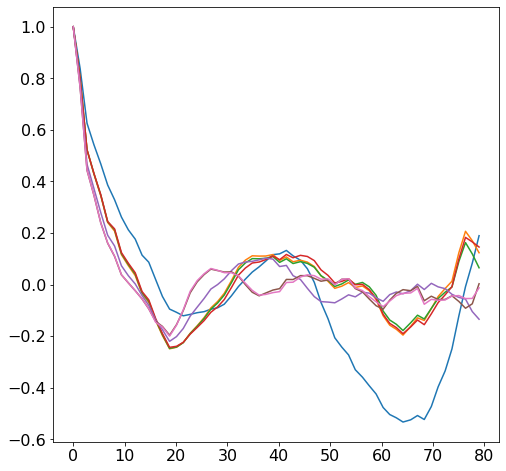

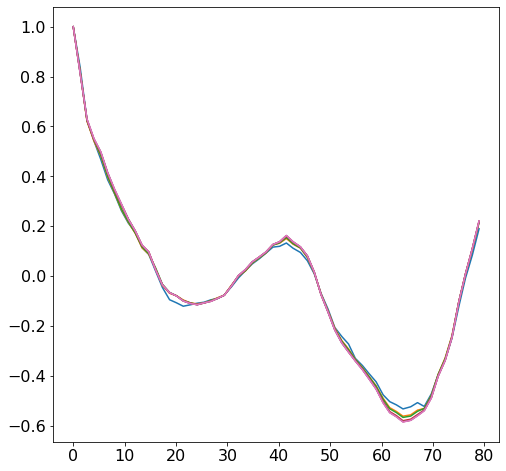

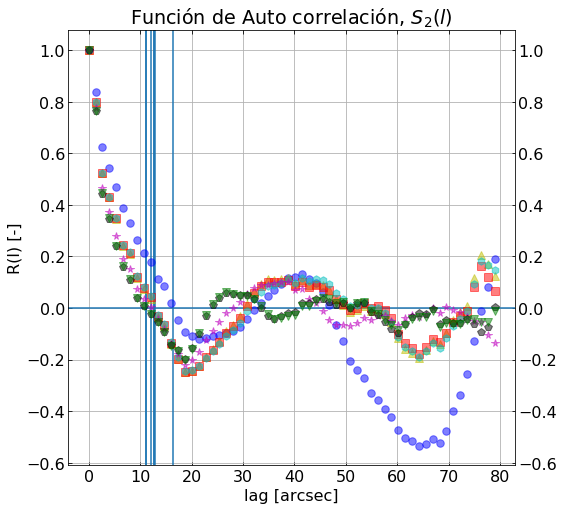

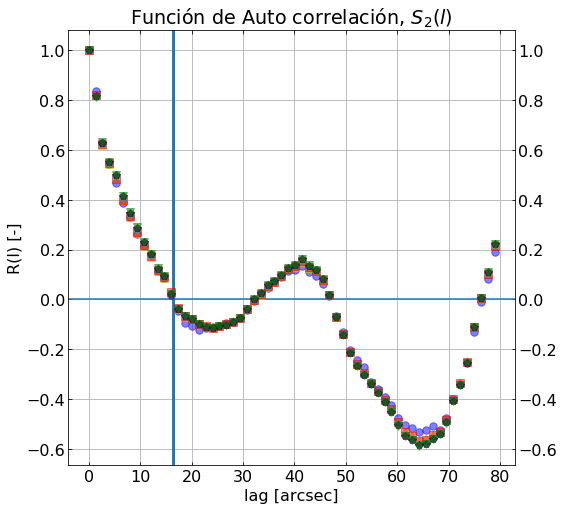

In [38]:
fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    plt.plot(AF1[i]['Lag'],AF1[i]['Nmqvd'])

fig, ax=plt.subplots(figsize=(8,8))
    
for i in range(n):
    plt.plot(AF2[i]['Lag'],AF2[i]['Nmqvd'])
    
marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF1Inter[i][0],AF1Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF1Data[y][i])



marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF2Inter[i][0],AF2Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF2Data[y][i])

1DPSD

In [39]:
PS1=dict()

for i in range(n):
    PS1[i]=ps(argo1[i])
    
PS2=dict()

for i in range(n):
    PS2[i]=ps(argo2[i])

In [40]:
xi=10
xf=29

PS1Data=dict()
mx=len(PS1[i]['k'])
PS1Pr=dict()

for i in range(n):
    PS1Data[i],PS1Pr[i]=LR(PS1[i]['k'][1:mx],PS1[i]['Pk'][1:mx],PS1[i]['Err'][1:mx],xi,xf,n)
    
PS2Data=dict()
PS2Pr=dict()

for i in range(n):
    PS2Data[i],PS2Pr[i]=LR(PS2[i]['k'][1:mx],PS2[i]['Pk'][1:mx],PS2[i]['Err'][1:mx],xi,xf,n)

In [41]:
PS1Data,PS2Data

({0:               R            eps     alpha  lags
  Value  0.619230  675684.869334 -1.440172  10.0
  Err    0.012533  152918.301566  0.045126  28.0,
  1:               R            eps     alpha  lags
  Value  0.621533  933406.349405 -1.534385  10.0
  Err    0.005907  196110.513031  0.039723  28.0,
  2:               R            eps     alpha  lags
  Value  0.621407  933700.213429 -1.534532  10.0
  Err    0.005906  196156.387576  0.039718  28.0,
  3:               R            eps     alpha  lags
  Value  0.622157  891682.584919 -1.525909  10.0
  Err    0.007815  186913.626579  0.039611  28.0,
  4:               R            eps     alpha  lags
  Value  0.626495  911770.984175 -1.532316  10.0
  Err    0.007251  196057.772449  0.041150  28.0,
  5:               R            eps     alpha  lags
  Value  0.619590  650938.933720 -1.421427  10.0
  Err    0.012441  157073.185653  0.049499  28.0,
  6:               R            eps     alpha  lags
  Value  0.617131  634286.435816 -1.414610

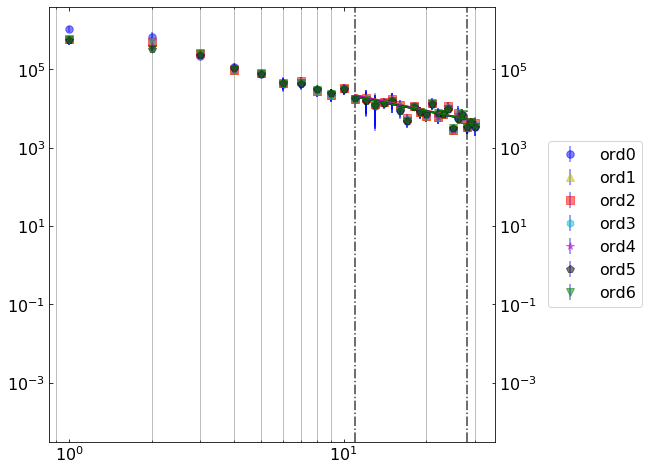

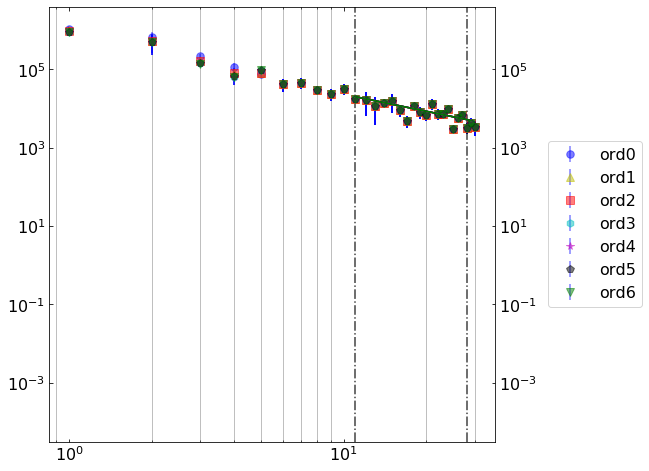

In [42]:
pltdata(PS1,PS1Pr,xi+1,xf,n)
pltdata(PS2,PS2Pr,xi+1,xf,n)

In [43]:
PS1k=dict()

for i in range(n):
    PS1k[i]=psk(argo1[i])
    
PS2k=dict()

for i in range(n):
    PS2k[i]=psk(argo2[i])

In [44]:
xi=10
xf=29

PS1kData=dict()
mx=len(PS1k[0]['k'])
PS1kPr=dict()


for i in range(n):
    PS1kData[i],PS1kPr[i]=LR(PS1k[i]['k'][1:mx],PS1k[i]['Pk'][1:mx],PS1k[i]['Err'][1:mx],xi,xf,n)
    
PS2kData=dict()
PS2kPr=dict()

for i in range(n):
    PS2kData[i],PS2kPr[i]=LR(PS2k[i]['k'][1:mx],PS2k[i]['Pk'][1:mx],PS2k[i]['Err'][1:mx],xi,xf,n)

In [45]:
PS1kData,PS2kData

({0:               R          eps     alpha   lags
  Value  0.569212  1957.451757 -0.608459  0.036
  Err    0.004557    73.620337  0.015287  0.262,
  1:               R          eps     alpha   lags
  Value  0.568407  1879.777175 -0.646597  0.036
  Err    0.000031    81.922206  0.013619  0.262,
  2:               R          eps     alpha   lags
  Value  0.568504  1878.725152 -0.646779  0.036
  Err    0.000016    81.917367  0.013611  0.262,
  3:               R          eps     alpha   lags
  Value  0.569323  1857.497363 -0.643233  0.036
  Err    0.001300    82.149329  0.013333  0.262,
  4:               R          eps     alpha   lags
  Value  0.571449  1850.186935 -0.644870  0.036
  Err    0.000583    79.849809  0.013846  0.262,
  5:               R          eps     alpha   lags
  Value  0.567868  2017.823571 -0.599615  0.036
  Err    0.004444    67.090330  0.017137  0.262,
  6:               R          eps     alpha   lags
  Value  0.567132  2027.575914 -0.597557  0.036
  Err    0.00

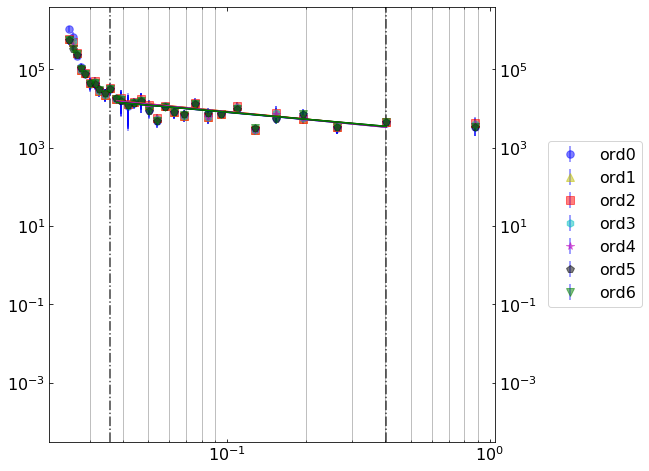

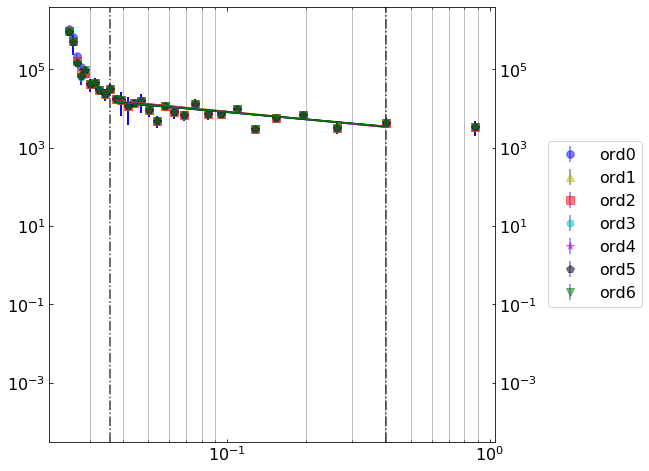

In [46]:
pltdata(PS1k,PS1kPr,xi,xf+1,n)
pltdata(PS2k,PS1kPr,xi,xf+1,n)

1DPSD Turbustat

In [47]:
PST1a=dict()
PST1b=dict()


for i in range(n):
    PST1a[i],PST1b[i]=pst(argo1[i])
    
PST2a=dict()
PST2b=dict()

for i in range(n):
    PST2a[i],PST1b[i]=pst(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/b

In [48]:
for i in range(n):
    print(PST1a[i].slope2D,PST1a[i].slope2D_err)
    


-1.650688569321548 0.16520135585513607
-1.8136846516043186 0.2565859756703115
-1.8130359310819362 0.21724704450191912
-1.8016804641195914 0.23333138863975544
-1.8463080939102048 0.1869720550556605
-1.6950735755531527 0.16741424353186063
-1.6458657861881314 0.2016240301950949


In [49]:
for i in range(n):
    print(PST2a[i].slope2D,PST2a[i].slope2D_err)

-1.650688569321548 0.18896249298985224
-1.7259674776847245 0.16011414743567254
-1.7230366685302783 0.13436216291986947
-1.7174515093858946 0.13329131133582672
-1.5868165129437284 0.14425844975686541
-1.636954220361147 0.13090017610046767
-1.6323416274053089 0.13514525027230861


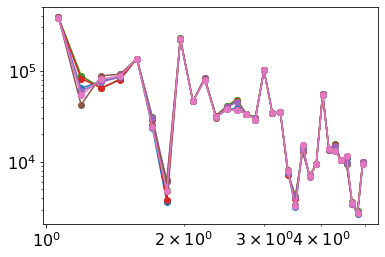

In [50]:
for i in range(n):
    plt.loglog(PST1a[i].wavenumbers,PST1a[i].ps1D,'o-', label=str(i))
    #plt.legend()

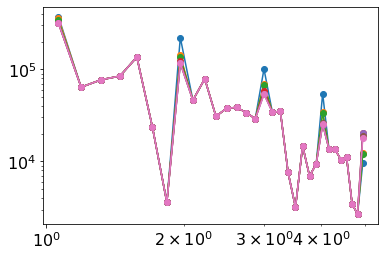

In [51]:
for i in range(n):
    plt.loglog(PST2a[i].wavenumbers,PST2a[i].ps1D,'o-', label=str(i))
    #plt.legend()

In [52]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 371.2101848125458 seconds ---


In [53]:
#SF1

In [54]:
#SF1.to_csv('SF1.csv')